<h1> Is there a statistical difference in the odds of winning a game when a team is playing in front of a home crowd?</h1>

<h3> Null Hypothesis:</h3> <b>There is no difference in projected win percentage between playing at a home field and playing in an away field.</b>

<h3> Alternative Hypothesis</h3> <b>There is a statistical advantage in being able to play with a home field.</b>

<h2> Observation </h2>
Our goal is to determine how we should be handicapping our models to project a difference in home versus away games - with consistent enough evidence, this can be used to calculate betting lines in a way that would only require the relative strengths of the teams. Then a handicap can be applied to these predictions accounting for Home and Away field advantages.

<h2> Experiment </h2>
Our experiment has been conducted other times with other contributors to this data set, including <a href = "https://www.kaggle.com/aiyoyo/exploring-home-team-advantage"> this experiment</a>. Here we are going to be applying a T Test to our normalized Sample Distributions of Sample Means of the averages of both Home and Away wins to determine a p-score as to the likelihood that home field advantage plays a role.

Our dataset contains much more information than we would otherwise need to conduct this analysis, some of which we may use for further questions. The entire dataset's structure looks like:

Table | Total Rows | Total Columns | Columns (edited for relevance)
--- | :- | :--- | :---:
Country | 11 | 2 | id, name
League | 11 | 3 | id, country_id, name
Match | 25979 | 115 | id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, (others)
Player | 11060 | 7 | id, player_api_id, player_name, player_fifa_api_id, birthday, height, weight
Player_Attributes | 183978 | 42 | id, player_fifa_api_id, player_api_id, date, overall_rating, (other FIFA related statistics)
sqlite_sequence | 7 | 2 | name, seq
Team | 299 | 5 | id, team_api_id, team_fifa_api_id, team_long_name, team_short_name
Team_Attributes | 1458 | 25 | d, team_fifa_api_id, team_api_id, date, buildUpPlaySpeed, buildUpPlaySpeedClass, buildUpPlayDribbling, buildUpPlayDribblingClass, buildUpPlayPassing, buildUpPlayPassingClass, buildUpPlayPositioningClass, chanceCreationPassing,  chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression,  defenceTeamWidth, (other Class related Attributes)

<h2> Analysis </h2>

<b>Importing Libraries</b>

In [5]:
import sqlite3 
conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

First, we are going to start with a couple of queries from the relevant tables that we want to use, really just querying everything and then adding the column names to our Pandas Dataframe. Let's do this with our Match SQLite Data. 

In [6]:
query = """
SELECT *
FROM Match
"""
c.execute(query)
data = c.fetchall()
df3 = pd.DataFrame(data)
column_names3 = []
for x in range(len(c.description)):
    column3 = c.description[x] 
    column_names3.append(column3[0])
Match = df3
Match.columns = column_names3
Match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


To get a better look at some of the data we are going go join and assess, we also want to do this same query with our League data...

In [7]:
query = """
SELECT *
FROM League
"""
c.execute(query)
data = c.fetchall()
df2 = pd.DataFrame(data)
column_names2 = []
for x in range(len(c.description)):
    column2 = c.description[x] 
    column_names2.append(column2[0])
League = df2
League.columns = column_names2
League.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


as well as our Team data.

In [8]:
query = """
SELECT *
FROM Team
"""
c.execute(query)
data = c.fetchall()
df7 = pd.DataFrame(data)
column_names7 = []
for x in range(len(c.description)):
    column7 = c.description[x] 
    column_names7.append(column7[0])
Team = df7
Team.columns = column_names7
Team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


Getting the information on these Tables isn't really doing a whole lot for us, but you'll notice that our more advanced SQL Query below involves joining information in all three of these tables.

Now that we have a better look at what these particular tables look like, we can join the information we need as well as add some columns that may be useful to us in our attempt to answer our Hypothesis. In this case, we will need to add some columns that haven't yet been created in this Dataset. 
<br>-Which one of the individual matches listed in our dataset resulted in Home Wins? 
<br>-Which of the matches resulted in Away Wins? 
<br>Which ones resulted in Draws? For our Hypothesis in Question 1, we won't be doing much with the Draw data, but it is still nice to have.

In [9]:
CustomZ_match = pd.read_sql("""SELECT Match.id,  
                                        League.name AS league_name, 
                                        season,
                                        HT.team_long_name AS  home_team,
                                        AT.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN League on League.id = Match.league_id
                                JOIN Team AS HT on HT.team_api_id = Match.home_team_api_id
                                JOIN Team AS AT on AT.team_api_id = Match.away_team_api_id
                                ORDER by home_team;""", conn)
CustomZ_match['HomeWin'] = 0
CustomZ_match.loc[CustomZ_match['home_team_goal'] > CustomZ_match['away_team_goal'], "HomeWin"] = 1
CustomZ_match['AwayWin'] = 0
CustomZ_match.loc[CustomZ_match['away_team_goal'] > CustomZ_match['home_team_goal'], "AwayWin"] = 1
CustomZ_match['Draw'] = 0
CustomZ_match.loc[CustomZ_match['home_team_goal'] == CustomZ_match['away_team_goal'], "Draw"] = 1
CustomZ_match.head()

,id,league_name,season,home_team,away_team,home_team_goal,away_team_goal,HomeWin,AwayWin,Draw
0,8437,Germany 1. Bundesliga,2010/2011,1. FC Kaiserslautern,Borussia Mönchengladbach,3,0,1,0,0
1,8455,Germany 1. Bundesliga,2010/2011,1. FC Kaiserslautern,VfB Stuttgart,3,3,0,0,1
2,8474,Germany 1. Bundesliga,2010/2011,1. FC Kaiserslautern,FC Schalke 04,5,0,1,0,0
3,8492,Germany 1. Bundesliga,2010/2011,1. FC Kaiserslautern,VfL Wolfsburg,0,0,0,0,1
4,8509,Germany 1. Bundesliga,2010/2011,1. FC Kaiserslautern,1. FC Köln,1,1,0,0,1


This shows us an table with individual matches showing the Home Wins, Away Wins, and Draws, ordered by the Home Team. The next step here is to apply the sums of these values to two separate charts and then graph these charts.

In [10]:
HomeZZ= CustomZ_match.groupby(['home_team']).sum()
HomeZZ.head()

,id,home_team_goal,away_team_goal,HomeWin,AwayWin,Draw
home_team,,,,,,
1. FC Kaiserslautern,296780,37,47,8,15,11
1. FC Köln,911073,116,139,32,39,31
1. FC Nürnberg,755016,108,118,30,34,21
1. FSV Mainz 05,1093063,171,129,55,35,29
AC Ajaccio,368804,64,77,16,22,19


I can also do this with the Away Teams. With the combined wins for Home Teams and away teams, we can make charts showing the odds of winning Home and Away games.

In [11]:
AwayZZ= CustomZ_match.groupby(['away_team']).sum()
AwayZZ.head()

,id,home_team_goal,away_team_goal,HomeWin,AwayWin,Draw
away_team,,,,,,
1. FC Kaiserslautern,296686,58,35,18,9,7
1. FC Köln,910947,172,110,51,28,23
1. FC Nürnberg,754592,151,85,44,19,22
1. FSV Mainz 05,1093199,190,149,50,33,36
AC Ajaccio,369557,107,52,30,6,21


You'll notice that because we used the ```groupby``` function, the index of these tables is now set to the Home Team and the Away Team. The way I have chosen to calculate the odds of winning, we are going to need these Indexes to be reset. I can do that with the ```reset_index``` function.

In [12]:
HomeZZZ = HomeZZ.reset_index()
home_dict=HomeZZZ.to_dict('records')
names=[]
odds=[]
for i in home_dict:
    names.append(i['home_team'])
    odd= (i['HomeWin']/(i['HomeWin']+i['AwayWin']+i['Draw']))
    odds.append(odd)
ZachHome = pd.DataFrame(data=list(zip(names, odds)))
ZachHome.columns = ['Team', 'Odds of Winning Home Games']
ZachHome.head()

,Team,Odds of Winning Home Games
0,1. FC Kaiserslautern,0.235294
1,1. FC Köln,0.313725
2,1. FC Nürnberg,0.352941
3,1. FSV Mainz 05,0.462185
4,AC Ajaccio,0.280702


What's being done here? First I ```reset_index```, then I convert my dataframe to a Dictionary using ```to_dict['records']```. I then create two empty lists, and I set a ```for``` loop to ```append``` those empty lists with the names of the Home Teams, and the odds of the Home Teams winning.
<br>
The odds of the Home Team winning are the number of Home Wins divided by the number of Total Games (Number of Home Wins + Number of Away Wins + Number of Draws).

Let's do the same with Away Odds too.

In [13]:
AwayZZZ = AwayZZ.reset_index()
away_dict=AwayZZZ.to_dict('records')
awaynames=[]
awayodds=[]
for i in away_dict:
    awaynames.append(i['away_team'])
    awayodd= (i['AwayWin']/(i['AwayWin']+i['HomeWin']+i['Draw']))
    awayodds.append(awayodd)
ZachAway = pd.DataFrame(data=list(zip(awaynames, awayodds)))
ZachAway.columns = ['Team', 'Odds of Winning Away Games']
ZachAway.head()

,Team,Odds of Winning Away Games
0,1. FC Kaiserslautern,0.264706
1,1. FC Köln,0.274510
2,1. FC Nürnberg,0.223529
3,1. FSV Mainz 05,0.277311
4,AC Ajaccio,0.105263


There are 296 teams in our dataset. By calculating the respective odds of each of our Teams Winning Home Games and Away Games, we can get a histogram of the distribution each Teams' odds. First though, let's get a quick description of the odds of winning both Home and Away games - this should show some clear trends that many people may be expecting.

In [14]:
ZachHome.describe()

,Odds of Winning Home Games
count,296.000000
mean,0.404473
std,0.147253
min,0.000000
25%,0.314683
50%,0.385585
75%,0.474748
max,0.861842


In [15]:
ZachAway.describe()

,Odds of Winning Away Games
count,296.000000
mean,0.247667
std,0.124221
min,0.052632
25%,0.166667
50%,0.222876
75%,0.306923
max,0.684211


So the average odds of winning for Home Games is set at 40.4 Percent. The average odds of winning Away Games is set at 24.7 Percent. So far it seems to be a pretty sizeable Home Field advantage. But what does the distribution of these individual odds by team tell us?

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


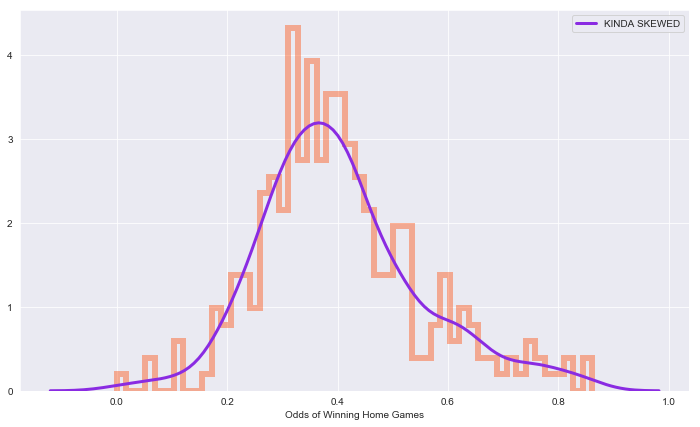

In [16]:
#rcParams was uploaded earlier. Changes size of plot.
rcParams['figure.figsize'] = 12,7
sns.set_style("darkgrid")
sns.distplot(ZachHome['Odds of Winning Home Games'], bins= 50, kde=True, rug=False, 
kde_kws={'color': 'blueviolet', 'lw': '3', 'label': 'KINDA SKEWED'}, hist_kws={'histtype': 'step', 
'linewidth': 6}, color = "orangered")
plt.show()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


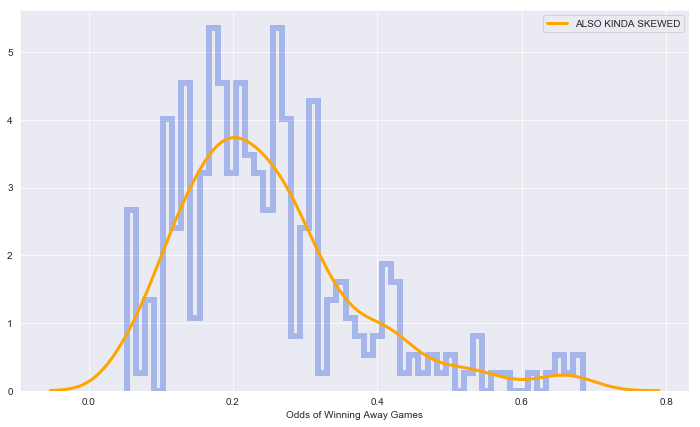

In [17]:
rcParams['figure.figsize'] = 12,7
sns.set_style("darkgrid")

sns.distplot(ZachAway['Odds of Winning Away Games'], bins=50, kde=True, rug=False, 
kde_kws= {'color': 'orange', 'lw': '3', 'label': 'ALSO KINDA SKEWED'}, 
hist_kws={'histtype': 'step', 'linewidth': 6}, color ='royalblue')
plt.show()

It appears from our KDE curves that these graphs are probably not Normally distributed enough to do a T-Test on. In order for us to create a Normal Distribution of this data, we will want to utilize the Central Limit Theorem to create a Sample Distribution of Sample Means.
<br> We can create a function ```one_sample_mean``` to make a random sampling of 10 teams at a time, and return the mean of these sample results.

In [18]:
def one_sample_mean(x):
    sample = np.random.choice(x,size=10,replace=True)
    return sample.mean()

What happens if we run this 10 team sampling 20,000 times?

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


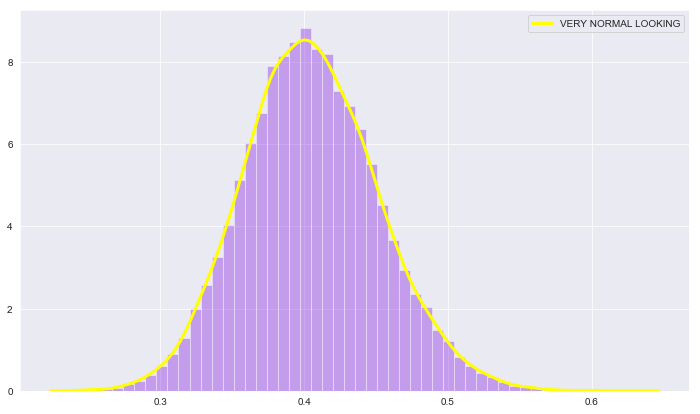

In [19]:
ZMeanHome = [one_sample_mean(ZachHome['Odds of Winning Home Games']) for i in range(20000)]
rcParams['figure.figsize'] = 12,7
sns.distplot(ZMeanHome, bins= 50, kde=True, 
kde_kws={"color": 'yellow', 'lw': '3', 'label': 'VERY NORMAL LOOKING'},  color="blueviolet")
plt.show()

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


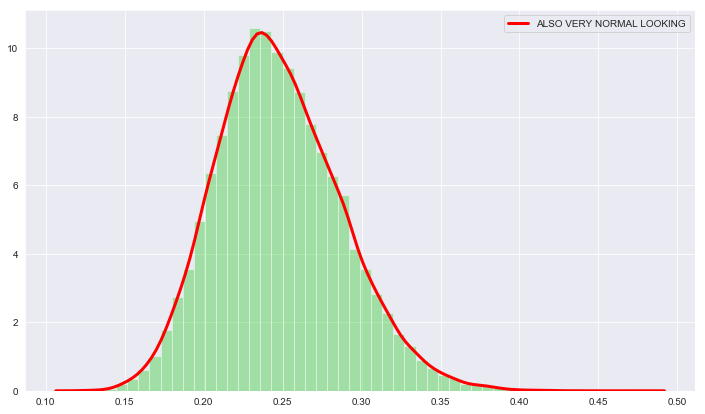

In [20]:
ZMeanAway = [one_sample_mean(ZachAway['Odds of Winning Away Games']) for i in range(20000)]
rcParams['figure.figsize'] = 12,7
sns.distplot(ZMeanAway, bins= 50, kde=True, 
kde_kws={"color": 'r', 'lw': '3', 'label': 'ALSO VERY NORMAL LOOKING'}, color='limegreen')
plt.show()

And also we can make a little plot with both of these put together to see how interrelated they are.

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


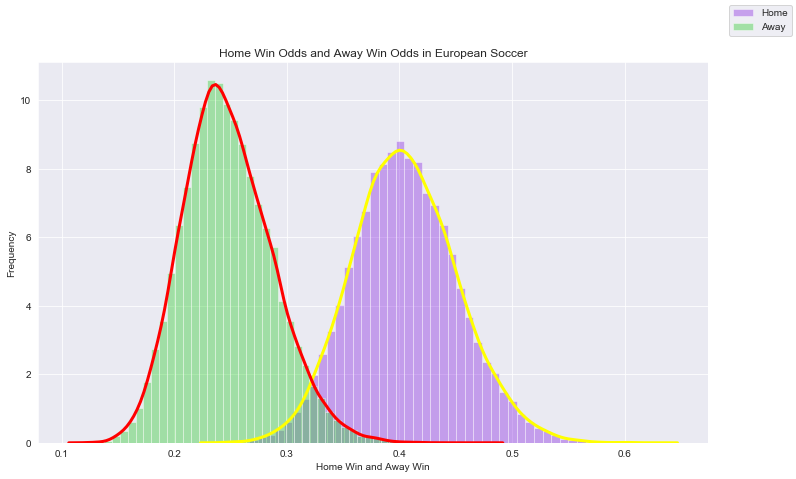

In [27]:
rcParams['figure.figsize'] = 12,7
fig, ax = plt.subplots()
sns.distplot(ZMeanHome, ax=ax, bins= 50, kde=True, 
kde_kws={"color": 'yellow', 'lw': '3'},  color="blueviolet")
sns.distplot(ZMeanAway, ax=ax, bins= 50, kde=True, 
kde_kws={"color": 'r', 'lw': '3'}, color='limegreen')
fig.legend(labels  = ['Home', 'Away'])
plt.xlabel('Home Win and Away Win')
plt.ylabel('Frequency')
plt.title('Home Win Odds and Away Win Odds in European Soccer')
plt.show()

One thing worth noting about this chart is that if we were to increase our sample size from 10
teams to 100 teams and run a the same Sample Distribution of the Sample Means, we would not be
seeing these charts overlap like they do. So while it can be somewhat tempting to see the crossing of these charts as a potential to reject the Alternative Hypothesis, running our T-Test is really just going to take a look at our Mean of these charts, which since they're fairly normally distributed will be close to their peaks (Mode). And as we can see those peaks are pretty far apart.

So now that we have very normally distributed plots, we can perform a quick T-Test to determine
whether or not we can accept our relatively apparent <b>Alternative Hypothesis</b>. Let's do
that final step shall we?

In [ ]:
from scipy import stats
np.round(stats.t.ppf(1 - 0.05, df = 295),3)

Here we are just retrieving our T-Critical Value. It's pretty fun. 

In [77]:
scipy.stats.ttest_ind(ZMeanHome,ZMeanAway)

Ttest_indResult(statistic=366.9899372972111, pvalue=0.0)

And here are the results we have been looking for! This T-statistic is so far out of the stratosphere that we can reject the Null Hypothesis all day. We don't even have to think twice about it really.

<h1> VERDICT </h1>

NULL HYPOTHESIS...... REJECTED!